# PSLG overlaying

Напомню, что ППЛГ - плоский прямолинейный граф. РСДС - ребренный список с двойными связями.
ППЛГ удобно хранить с помощью РСДС.

Пересечение двух ППЛГ $S_1$ и $S_2$ - такой ППЛГ $O(S_1,S_2)$, у которого грань $f$ принадлежит $O(S_1,S_2)$ тогда и только тогда, если существуют грани $f_1$ из $S_1$ и $f_2$ из $S_2$, что $f$ - максимальное связанное подмножество пересечения $f_1$ и $f_2$.
<img src="images/пересечение пплг.png" />

Задачу о пересечении многоугольников сводится к задачи о пересечении двух РСДС, которую и будем решать:
## Задача
Необходимо построить РСДС для $O(S_1,S_2)$ по РСДС $S_1$ и $S_2$. 
Для удобства будем для каждой грани из $O(S_1,S_2)$ хранить ссылки на грани $S_1$ и $S_2$.

## Алгоритм
Алгоритм работает в два этапа:
* Нахождение пересечения ребер $S_1$ и $S_2$
* Построение граней $O(S_1,S2)$

### Нахождение пересечений ребер $S_1$ и $S_2$

Напомню, что алгоритм "заметающей прямой" решает задачу о пересечении множества отрезков и работает за $O((n+I)*log(n))$, где $I$ - количество пересечений и использует $O(n)$ памяти. Главная идея этого алгоритма в том, что есть горизонтальная прямая и она движется вниз и следит за событиями: 
* прямая пересекла верхний конец отрезка
* прямая пересекла нижний конец отрезка
* прямая пересекла точку пересечения пары отрезков
<img src="images/заметающая прямая.png" />

Нахождение пересечений ребер $S_1$ и $S_2$ базируется на алгоритме "заметающей прямой" с небольшими изменениями:
* Скопируем ППЛГ $S_1$ и $S_2$ в новый РСДС.
* На новом РСДС запускаем алгоритм заметающей прямой на множестве ребер из $S_1$ и $S_2$. 
* Если прямая пересекла точку пересечения ребра, которые принадлежат одному ППЛГ, то переходим к следующему событию.
* Иначе надо изменить РСДС. Возможны случаи:
    * Вершина ребра $e_2$ проходит через ребро $e_1$, разбивая его на два новых ребра
    * Ребро $e_1$ пересекает ребро $e_2$ и образуется 4 новых ребра
    * Ребра $e_1$ и $e_2$ пересекаются в вершине
    * Вершина ребра $e_1$ проходит через ребро $e_2$, разбивая его на 2 новых ребра
    * Ребра $e_1$ и $e_2$ имеют общий отрезок и образуют новое ребро
<img src="images/варианты пересечения ребер.png" />

Рассмотрю алгоритм разбора для первого случая, остальные случаи обрабатываются аналогично.
Пусть вершина ребра $e$ из $S_1$ проходит через ребро $v$ из $S_2$, разбивая его на два новых ребра. Ребро $e$ заменяется двумя ребрами $e'$ и $e''$ . Два полуребра, соотвествующие ребру $e$, заменяются на 4 полуребра (см рисунок). 
<img src="images/создание новых полуребер.png" />
Устанавливаем ссылки на ребра и  и обновляем ссылки на следующие полуребра для $h_1$ и $h_4$ (пусть эти полуребра будут $h_5$ и $h_6$ соответсвенное), так же не забываем обновить ссылки на предыдущие полуребра у $h_5$ и $h_6$. 
<img src="images/ссылки новых полуребер1.png" />
Потом надо обновить ссылки для поребер инцедентных вершине $v$. Для этого рассмотрим полуребро $h_3$ и свяжем его с первым полуребром, видимым из $e'$ при обходе по часовой стрелке и исходящем из $v$. Полуребро $h_4$ свяжем с первым полуребром, идущим в $v$, при обходе против часовой стрелки. Аналогично надо сделать для ребра $e''$.
<img src="images/ссылки новых полуребер2.png" />
### Время работы
Разбор каждого случая происходит за $O(p)$ где $p$ - степень вершины , так как создание и обновление ссылок на полуребра работает $O(1)$, а поиск соседних полуребер определенияется за $O(p)$. Значит, обновление РСДС не увеличивает время работы алгоритма заметающей прямой. Из чего можно сделать вывод, что нахождение информации о вершинах и итогового РСДС работает за $O((n+k)*log(n))$, где $k$ - количество точек пересечений, $n$ - суммарная сложность $S_1$ и $S_2$.

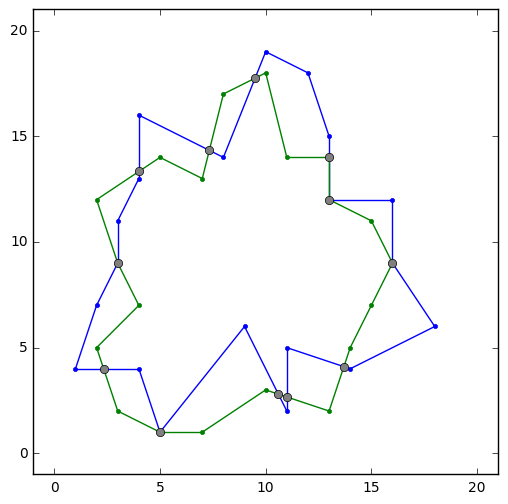

In [37]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
from descartes import PolygonPatch
from sympy import Polygon as sympyPolygon# -> пересечение границ
from sympy import Segment, Point2D

from ipywidgets import interact
from IPython.display import display

MAX_X = 20
MIN_X = 0
MAX_Y = 20
MIN_Y = 0
COL_POINTS_FIRST = 20
COL_POINTS_SECOND = 20

def generateFigure(ctrX, ctrY, aveRadius, irregularity, spikeyness, numVerts):
    irregularity = clip( irregularity, 0,1 ) * 2*math.pi / numVerts
    spikeyness = clip( spikeyness, 0,1 ) * aveRadius

    # generate n angle steps
    angleSteps = []
    lower = (2*math.pi / numVerts) - irregularity
    upper = (2*math.pi / numVerts) + irregularity
    sum = 0
    for i in range(numVerts) :
        tmp = random.uniform(lower, upper)
        angleSteps.append( tmp )
        sum = sum + tmp

    # normalize the steps so that point 0 and point n+1 are the same
    k = sum / (2*math.pi)
    for i in range(numVerts) :
        angleSteps[i] = angleSteps[i] / k

    # now generate the points
    points = []
    angle = random.uniform(0, 2*math.pi)
    for i in range(numVerts) :
        r_i = clip( random.gauss(aveRadius, spikeyness), 0, 2*aveRadius )
        x = ctrX + r_i*math.cos(angle)
        y = ctrY + r_i*math.sin(angle)
        points.append( (int(x),int(y)) )

        angle = angle + angleSteps[i]

    return points

def clip(x, min, max) :
    if( min > max ) :  return x    
    elif( x < min ) :  return min
    elif( x > max ) :  return max
    else :             return x


fig = plt.figure(figsize = (6, 6))
ax1 = plt.subplot(111, aspect = 'equal')

q = []

def redrawClosest(point, color = 'black', look = '--', lookPoint='o'):
    for i in range(len(point)):
        drawPoint(point[i], color, lookPoint)
        drawLine(point[i - 1], point[i], color, look)

def drawIntersection(p):
    return
        
def drawPoint(point, color = 'red', look = '.'):
    q1, = ax1.plot(point[0], point[1], look, color = color)
    q.insert(-1, q1)

def drawLine(pointStart, pointEnd, color = 'red', look = '-'):
    q1, = ax1.plot([pointStart[0], pointEnd[0]], [pointStart[1], pointEnd[1]], look, color = color)
    q.insert(-1, q1)   

def onRelease(event):
    for i in range(len(q)):
        q[i].remove();
    q = []
    
def getPolygon(p):
    points = []
    for i in range(-1, len(p)):
        points.insert(-1, (p[i][0], p[i][1]))
    return sympyPolygon(*points)
    
fig.canvas.mpl_connect('button_release_event', onRelease)
size_x = MAX_X - MIN_X - 1
if size_x < 0:
    raise Exception('MAX_X must be more than MIN_X')
size_y = MAX_Y - MIN_Y - 1
if size_y < 0:
    raise Exception('MAX_Y must be moer than MIN_Y')
p1 = generateFigure(MIN_X + size_x / 2, MIN_Y + size_y / 2, min(size_x, size_y) / 2.5, 0.35, 0.2, COL_POINTS_FIRST)
p2 = generateFigure(MIN_X + size_x / 2, MIN_Y + size_y / 2, min(size_x, size_y) / 2.5, 0.35, 0.2, COL_POINTS_SECOND)
redrawClosest(p1,'blue','-','.')
redrawClosest(p2,'green','-','.')

p1 = getPolygon(p1)
p2 = getPolygon(p2)

p3 = p1.intersection(p2)
#x, y = p3.exterior.coords.xy
s = Segment(Point2D(0,0),Point2D(0,1))
p3Res=[]
for x in p3:
    if type(x) is type(s.p1):
        p3Res.insert(-1,[x.x,x.y])
#ax1.add_patch(PolygonPatch(p3))
redrawClosest(p3Res,'grey','.','o')
ax1.set_xlim(MIN_X - 1, MAX_X + 1)
ax1.set_ylim(MIN_Y - 1, MAX_X + 1)

display(fig)
plt.close()



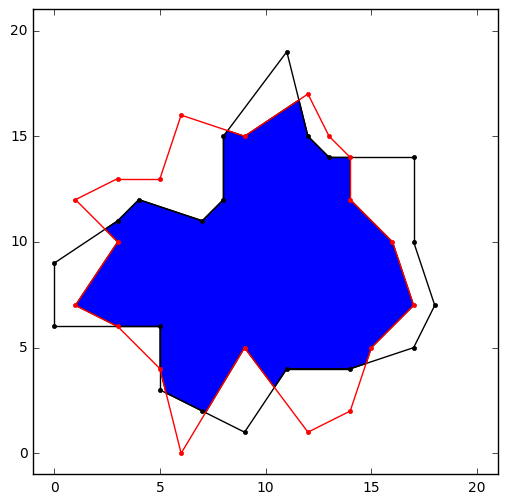

In [1]:
import math, random
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from descartes import PolygonPatch

from ipywidgets import interact
from IPython.display import display

MAX_X = 20
MIN_X = 0
MAX_Y = 20
MIN_Y = 0
COL_POINTS_FIRST = 20
COL_POINTS_SECOND = 20

def generateFigure(ctrX, ctrY, aveRadius, irregularity, spikeyness, numVerts):
    irregularity = clip( irregularity, 0,1 ) * 2*math.pi / numVerts
    spikeyness = clip( spikeyness, 0,1 ) * aveRadius

    # generate n angle steps
    angleSteps = []
    lower = (2*math.pi / numVerts) - irregularity
    upper = (2*math.pi / numVerts) + irregularity
    sum = 0
    for i in range(numVerts) :
        tmp = random.uniform(lower, upper)
        angleSteps.append( tmp )
        sum = sum + tmp

    # normalize the steps so that point 0 and point n+1 are the same
    k = sum / (2*math.pi)
    for i in range(numVerts) :
        angleSteps[i] = angleSteps[i] / k

    # now generate the points
    points = []
    angle = random.uniform(0, 2*math.pi)
    for i in range(numVerts) :
        r_i = clip( random.gauss(aveRadius, spikeyness), 0, 2*aveRadius )
        x = ctrX + r_i*math.cos(angle)
        y = ctrY + r_i*math.sin(angle)
        points.append( (int(x),int(y)) )

        angle = angle + angleSteps[i]

    return points

def clip(x, min, max) :
    if( min > max ) :  return x    
    elif( x < min ) :  return min
    elif( x > max ) :  return max
    else :             return x


fig = plt.figure(figsize = (6, 6))
ax1 = plt.subplot(111, aspect = 'equal')

q = []

def redrawClosest(point, color = 'black', look = '--'):
    points = np.array(point)
    for i in range(len(points)):
        drawPoint(point[i], color)
        drawLine(point[i - 1], point[i], color, look)
        
def drawPoint(point, color = 'red', look = '.'):
    q1, = ax1.plot(point[0], point[1], look, color = color)
    q.insert(-1, q1)

def drawLine(pointStart, pointEnd, color = 'red', look = '-'):
    q1, = ax1.plot([pointStart[0], pointEnd[0]], [pointStart[1], pointEnd[1]], look, color = color)
    q.insert(-1, q1)   

def onRelease(event):
    for i in range(len(q)):
        q[i].remove();
    q = []
    
def getPolygon(p):
    points = []
    for i in range(-1, len(p)):
        points.insert(-1, (p[i][0], p[i][1]))
    return Polygon(points)
    
fig.canvas.mpl_connect('button_release_event', onRelease)
size_x = MAX_X - MIN_X - 1
if size_x < 0:
    raise Exception('MAX_X must be more than MIN_X')
size_y = MAX_Y - MIN_Y - 1
if size_y < 0:
    raise Exception('MAX_Y must be moer than MIN_Y')
p1 = generateFigure(MIN_X + size_x / 2, MIN_Y + size_y / 2, min(size_x, size_y) / 2.5, 0.35, 0.2, COL_POINTS_FIRST)
p2 = generateFigure(MIN_X + size_x / 2, MIN_Y + size_y / 2, min(size_x, size_y) / 2.5, 0.35, 0.2, COL_POINTS_SECOND)
redrawClosest(p1,'black','-')
redrawClosest(p2,'red','-')

p1 = getPolygon(p1)
p2 = getPolygon(p2)

p3 = p1.intersection(p2)
x, y = p3.exterior.coords.xy
pRes3 = list([x[i],y[i]] for i in range(1,len(x)))
ax1.add_patch(PolygonPatch(p3))

ax1.set_xlim(MIN_X - 1, MAX_X + 1)
ax1.set_ylim(MIN_Y - 1, MAX_X + 1)
display(fig)
plt.close()
